**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import io
import os
import zipfile
import requests

from sklearn.cluster import DBSCAN
import hdbscan
import geopandas as gpd
from shapely.geometry import point
import contextily as ctx

import warnings
warnings.filterwarnings('ignore')


**Zip file operations**

In [2]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'
output_dir = './'
os.makedirs(output_dir, exist_ok=True)
response = requests.get(url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    for file_name in zip_ref.namelist():
        if file_name.endswith('.tif'):
            zip_ref.extract(file_name, output_dir)
            print(f'{file_name} is successfully downloaded!!')

Canada.tif is successfully downloaded!!


**Plotting and visualization function**

In [3]:
def plot_visualization(df, title='Museums Clustered by Proximity'):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs='EPSG:4326')
    gdf=gdf.to_crs(epsg=3857)

    no_noise = gdf[gdf['Cluster']!=-1]
    noise = gdf[gdf['Cluster']==-1]
    fig, ax = plt.subplots(figsize=(15, 10))

    noise.plot(ax=ax, color='k', ec='r', alpha=0.8, label='Noise Data')
    no_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='b', alpha=0.7, legend=False)
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)

    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()

**Loading Datas**

In [4]:
urls = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(urls, encoding='ISO-8859-1')
df.head(5)

,Index,Facility_Name,Source_Facility_Type,ODCAF_Facility_Type,Provider,Unit,Street_No,Street_Name,Postal_Code,City,Prov_Terr,Source_Format_Address,CSD_Name,CSDUID,PRUID,Latitude,Longitude
0,1,#Hashtag Gallery,..,gallery,toronto,..,801,dundas st w,M6J 1V2,toronto,on,801 dundas st w,Toronto,3520005,35,43.65169472,-79.40803272
1,2,'Ksan Historical Village & Museum,historic site-building or park,museum,canadian museums association,..,1500,62 hwy,V0J 1Y0,hazelton,bc,1500 hwy 62 hazelton british columbia v0j 1y0 ...,Hazelton,5949022,59,55.2645508,-127.6428124
2,3,'School Days' Museum,community/regional museum,museum,canadian museums association,..,427,queen st,E3B 5R6,fredericton,nb,427 queen st fredericton new brunswick e3b 5r6...,Fredericton,1310032,13,45.963283,-66.6419017
3,4,10 Austin Street,built heritage properties,heritage or historic site,moncton,..,10,austin st,E1C 1Z6,moncton,nb,10 austin st,Moncton,1307022,13,46.09247776,-64.78022946
4,5,10 Gates Dancing Inc.,arts,miscellaneous,ottawa,..,..,..,..,ottawa,on,..,Ottawa,3506008,35,45.40856224,-75.71536766


**Separating `Latitude` and `Longitude`**

In [5]:
df = df[['Latitude', 'Longitude']]

**Adding a function that separates nont convertable floats**

In [6]:
def is_valid_number(value):
    try:
        float(value) or int(value)
        return True
    except:
        return False
df_temp = df[df['Latitude'].apply(is_valid_number) & df['Longitude'].apply(is_valid_number)]

**Converting to numeric type**

In [7]:
df_temp[['Latitude', 'Longitude']] = df_temp[['Latitude', 'Longitude']].astype(float)

**Scaling data**

In [8]:
df_temp['Latitude'] = 2*df_temp['Latitude']

**Building model using `DBSCAN`**

In [9]:
model_db = DBSCAN(eps=1.0,
                  min_samples=3,
                  metric='euclidean')
model_db.fit(df_temp)

DBSCAN(eps=1.0, min_samples=3)

**Finding labels**

In [10]:
labels = model_db.fit_predict(df_temp)
df_temp['Cluster'] = labels

**Plotting data using predefined function**

In [11]:
df_temp['Cluster'].value_counts()

Cluster
 0     4643
 2      829
 10     515
 3      269
 7      171
-1       84
 14      25
 26      21
 6       20
 11      14
 17      12
 24      10
 22      10
 4        8
 31       7
 35       7
 12       7
 15       6
 34       6
 27       5
 32       5
 18       5
 1        5
 20       4
 33       4
 19       4
 38       4
 25       4
 16       4
 21       4
 9        4
 8        4
 37       3
 36       3
 5        3
 29       3
 30       3
 28       3
 13       3
 23       3
 39       3
Name: count, dtype: int64

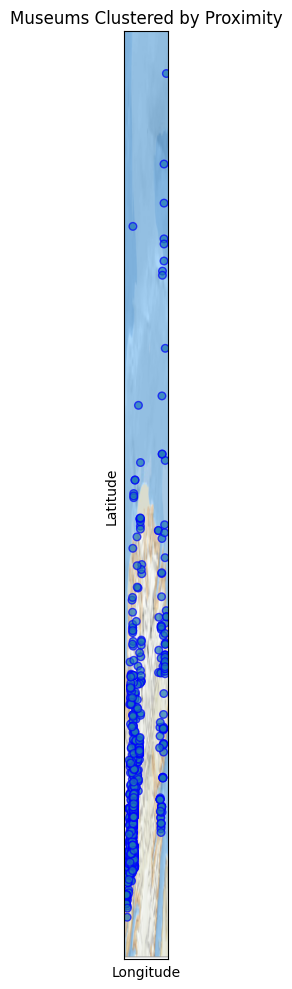

In [12]:
plot_visualization(df_temp, title='Museums Clustered by Proximity')

**Model building using `HDBSCAN`**

In [133]:
model_hdb = hdbscan.HDBSCAN(min_cluster_size=3, 
                            min_samples=None,
                            metric='euclidean')
model_hdb.fit(df_temp)

HDBSCAN(min_cluster_size=3)

In [134]:
df_temp['Cluster']=model_hdb.fit_predict(df_temp)
df_temp['Cluster'].value_counts()

Cluster
-1      1980
 316      79
 356      38
 163      37
 205      33
        ... 
 262       3
 502       3
 551       3
 124       3
 324       3
Name: count, Length: 639, dtype: int64

**Plotting visualization**

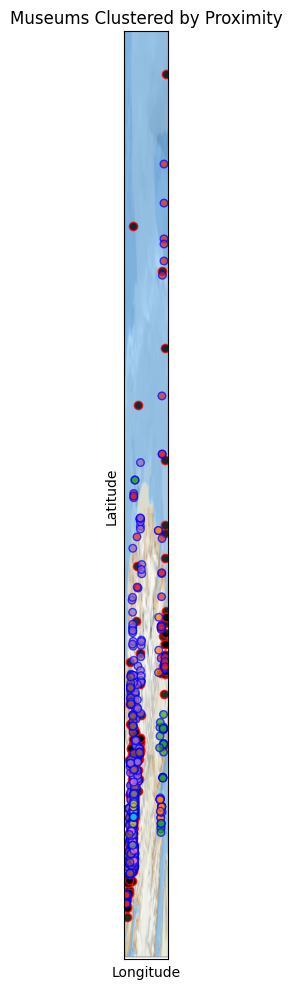

In [135]:
plot_visualization(df_temp, title = 'Museums Clustered by Proximity')